# Calculating Damkohler number for the simulations

## Calculate characteristic reaction time scales assuming first order rates
## Import residence time data
## Calculate Da for 95% loss

In [2]:
import os

#Import third party libraries
import pandas as pd
import numpy as np

#Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import data science library
import data_reader.data_processing as proc
import analyses.saturated_transient as sta

In [3]:
#Load standard values required to navigate through the datasets
data_dir = "E:/Zenodo_spatial_heterogeneity/"
Regimes = ["Slow", "Medium", "Fast"]
vels = [0.00038,0.0038,0.038]
gw = 1

scdict = proc.masterscenarios() #master dictionary of all spatially heterogeneous scenarios that were run
ratenames = proc.masterrates("saturated")

#Domains
Trial = list(t for t,values in scdict.items())
#Het = list(values['Het'] for t,values in scdict.items())
#Anis = list(values['Anis'] for t,values in scdict.items())

#Reactive species of concerns
gvarnames = ["DOC","DO","Ammonium","Nitrate","Nitrogen","TOC"]

### Import residence times/breakthrough times from tracer dataset

In [5]:
#chem_path_data = r"Y:\Home\khurana\4. Publications\Restructuring\Paper1\Figurecodes\massflux_withbreakthrough_forMartin_v4_complete.csv"
chem_path_data = r"Y:\Home\khurana\4. Publications\Restructuring\Paper1\Figurecodes\massflux_comparison_Original_complete_28012021.csv"#r"Y:\Home\khurana\4. Publications\Restructuring\Paper1\Figurecodes\masssflux_comparison_Original_complete.csv"
allchemdata = pd.read_csv(chem_path_data, sep = '\t')
print(allchemdata.columns)
allchemdata['Regime'] = allchemdata['Regime'].replace({'Equal':'Medium'})
chemdata = allchemdata[allchemdata.Time_series==0]
print(chemdata.Time_series.unique())
print(chemdata.Regime.unique())

Index(['Trial', 'Variance', 'Anisotropy', 'Domain', 'Regime', 'Time_series',
       'Chem', 'massflux_in', 'massflux_out', 'delmassflux', 'reldelmassflux',
       'normmassflux', 'Time', 'fraction', 'temporal_normmassflux_base',
       'spatial_normmassflux_base', 'temporal_reldelmassflux_base',
       'spatial_reldelmassflux_base', 'normmassflux_temporal_fraction',
       'normmassflux_spatial_fraction', 'reldelmassflux_temporal_fraction',
       'reldelmassflux_spatial_fraction', 'Da63'],
      dtype='object')
[0]
['Slow' 'Medium' 'Fast']


In [6]:
chemdatah = chemdata[chemdata.Trial=="H"]
print(chemdatah[["Trial","Chem","normmassflux_spatial_fraction"]])

     Trial      Chem  normmassflux_spatial_fraction
0        H       DOC                            1.0
1        H        DO                            1.0
2        H   Nitrate                            1.0
3        H  Ammonium                            1.0
4        H  Nitrogen                            1.0
5        H       TOC                            1.0
1176     H       DOC                            1.0
1177     H        DO                            1.0
1178     H   Nitrate                            1.0
1179     H  Ammonium                            1.0
1180     H  Nitrogen                            1.0
1181     H       TOC                            1.0
2352     H       DOC                            1.0
2353     H        DO                            1.0
2354     H   Nitrate                            1.0
2355     H  Ammonium                            1.0
2356     H  Nitrogen                            1.0
2357     H       TOC                            1.0


### Calculate pseudo first order reaction rate constant
- Load the chemican concentration profile at steady state
- Identify distance traveled for 50% normalized removal
- Ratio of this normalized removal and corresponding travel time is the reaction rate constant

In [7]:
row = []
for r,v,p in zip(Regimes,vels,[2,12,22]):
    print(r)
    if r=="Medium":
        reg="Equal"
    else:
        reg=r
    for t in Trial:
        filename = reg+"AR_0_NS-A"+t+"_df.npy"
        data = np.load(os.path.join(data_dir,filename))
        conctime, TotalFlow, Headinlettime = sta.calcconcmasstimenew (data,0,50,0,30, 51, gvarnames,"Saturated")
        for g in gvarnames:
            idx = gvarnames.index(g)
            inletconc = conctime[-1, 0, idx]
            outletconc = conctime[-1,-1,idx]
            normconc = outletconc/inletconc
            row.append([r,v,p,t,g,inletconc, outletconc, normconc])

Slow
Medium
Fast


In [8]:
data = pd.DataFrame.from_records(row, columns = ["Regime", "Velocity", "Pe","Trial", "Chem", "Conc_in", "Conc_out", "Normconc"])
for pe, vel, Reg in zip([2,11,22], vels,Regimes):
    for c in gvarnames:
        base = data.loc[(data.Regime == Reg) & (data.Chem == c) & (data.Trial == 'H')]['Normconc'].values[0]
        data.loc[(data.Regime == Reg) & (data.Chem == c), 'base'] = base
data['rel_normconc'] = data.Normconc/data.base

In [9]:
timedata = pd.merge(data, chemdata, on=['Regime','Trial','Chem'])
timedata["k"] = -1*np.log(timedata.Normconc)/timedata.Time
print(timedata[["Regime", "Chem", "k"]].groupby(["Regime", "Chem"]).mean())

                        k
Regime Chem              
Fast   Ammonium  0.068590
       DO        1.255664
       DOC       0.206500
       Nitrate   0.031839
       Nitrogen  0.026442
       TOC       0.143979
Medium Ammonium  0.012170
       DO        0.293545
       DOC       0.045650
       Nitrate   0.050710
       Nitrogen  0.036687
       TOC       0.029972
Slow   Ammonium  0.001206
       DO        0.029889
       DOC       0.004954
       Nitrate   0.007385
       Nitrogen  0.004477
       TOC       0.001988


In [10]:
datah = timedata[timedata.Trial=="H"]
print(datah[["Regime", "Trial","Chem", "k","reldelmassflux_spatial_fraction","Normconc","rel_normconc"]])

     Regime Trial      Chem         k  reldelmassflux_spatial_fraction  \
0      Slow     H       DOC  0.004378                              1.0   
1      Slow     H        DO  0.026612                              1.0   
2      Slow     H  Ammonium  0.001076                              1.0   
3      Slow     H   Nitrate  0.006698                              1.0   
4      Slow     H  Nitrogen  0.004116                              1.0   
5      Slow     H       TOC  0.001926                              1.0   
294  Medium     H       DOC  0.034932                              1.0   
295  Medium     H        DO  0.216597                              1.0   
296  Medium     H  Ammonium  0.009028                              1.0   
297  Medium     H   Nitrate  0.044971                              1.0   
298  Medium     H  Nitrogen  0.031774                              1.0   
299  Medium     H       TOC  0.023279                              1.0   
588    Fast     H       DOC  0.154048 

In [11]:
thresh = 0.05
steps = [500 * 0.005, 2 * 0.005, 2 * 0.0005]
nc = timedata[timedata["Normconc"] < thresh].index
for n in nc:
    r = timedata.iloc[n]["Regime"]
    r = reg
    if r=="Medium":
        reg="Equal"
    t = timedata.iloc[n]["Trial"]
    g = timedata.iloc[n]["Chem"]
    inletconc = timedata.iloc[n]["Conc_in"]
    filename = reg+"AR_0_NS-A"+t+"_df.npy"
    concdata = np.load(os.path.join(data_dir,filename))
    conctime, TotalFlow, Headinlettime = sta.calcconcmasstimenew (concdata,0,50,0,30, 51, [g],"Saturated")        
    tracer_dir = "X:/Saturated_flow/Steady_state/Tracer_studies/" + Reg + "AR/NS-A"+t+"/"
    tracerfile = "NS-A"+t+"_df.npy"
    tracerdata = np.load(os.path.join(tracer_dir,tracerfile))
    tracertime, TracerFlow, TracerHeadinlettime = sta.calcconcmasstimenew (tracerdata,0,50,0,30, 51, ["Tracer"],"Saturated")            
    idx5 = np.where(conctime[-1, :, 0]<thresh*inletconc)[0]
    if idx5.size != 0:
        point = idx5[0]
        loss = conctime[-1, point, 0]/inletconc
        timidx = np.where(np.round(tracertime[:, point, 0], 3) > 10)
        tim = steps[Regimes.index(r)] * timidx[0][0]
        k = -1*np.log(loss)/tim
        timedata.iloc[n, timedata.columns.get_loc("k")] = k
selected_k = "k"
timedata["tau63"] = -np.log(0.37)/timedata[selected_k].astype(float)
timedata["Da63"] = timedata.Time/timedata.tau63
#Squareroot transformation
#timedata["DaPe63_sqrt"] = np.sqrt(timedata.Da63/timedata.Pe)
#timedata["DaPe63_"] = np.log(timedata.Da63/timedata.Pe)
timedata.to_csv("Y:/Home/khurana/4. Publications/Restructuring/Paper1/Figurecodes/Da_29012021_95pcloss.csv")

### Consolidate information in a Pandas dataframe and explore the values

In [12]:
#kdf = pd.DataFrame.from_records(row, columns = ["Regime", "Velocity", "Pe","Trial", "Chem", "loss", "tim", "k", "Flag"])
#kdfnew = pd.merge(timedata, kdf[["Regime", "Chem", "loss", "tim", "k", "Flag"]], on=['Regime','Chem'])
print(timedata[["Regime", "Chem", "k", "tau63", "Da63"]].groupby(["Regime", "Chem"]).mean())

                        k       tau63       Da63
Regime Chem                                     
Fast   Ammonium  0.068590   16.006598   0.104846
       DO        1.221284    0.848096   2.168682
       DOC       0.206500    5.294286   0.316920
       Nitrate   0.031839   85.939604   0.032582
       Nitrogen  0.026442   91.742745   0.027842
       TOC       0.143979    7.612739   0.220446
Medium Ammonium  0.012170   88.943792   0.205121
       DO        0.681773    2.528794  14.101570
       DOC       0.045650   23.428317   0.776235
       Nitrate   0.050710   20.061720   0.903303
       Nitrogen  0.036687   27.855866   0.649858
       TOC       0.029972   35.406033   0.512935
Slow   Ammonium  0.001206  839.490558   0.220843
       DO        0.476941   22.638002  97.586391
       DOC       0.004954  204.458610   0.906965
       Nitrate   0.007385  136.618195   1.355085
       Nitrogen  0.004477  225.478008   0.821497
       TOC       0.001988  512.137468   0.364779


### Explore distribution of generated Damkohler numbers

In [7]:
#Load data
timedata = pd.read_csv("Y:/Home/khurana/4. Publications/Restructuring/Paper1/Figurecodes/Da_29012021_95pcloss.csv")

In [11]:
print(timedata.Regime.unique())
timedata["lnDa"] = np.log(timedata.Da63)
timedata["lnDaPe"] = np.log(timedata.Da63/timedata.Pe)
timedata["log10Da"] = np.log10(timedata.Da63)
timedata["log10DaPe"] = np.log10(timedata.Da63/timedata.Pe)
timedata["DaPe"] = timedata.Da63/timedata.Pe

['Slow' 'Medium' 'Fast']


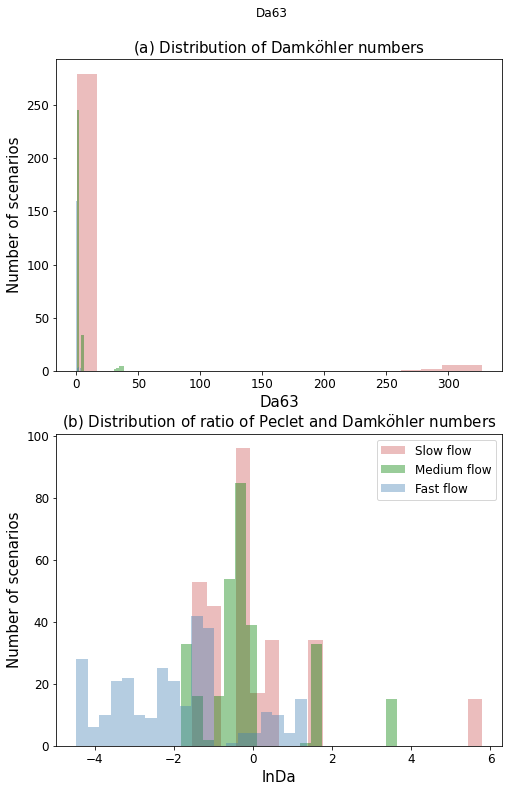

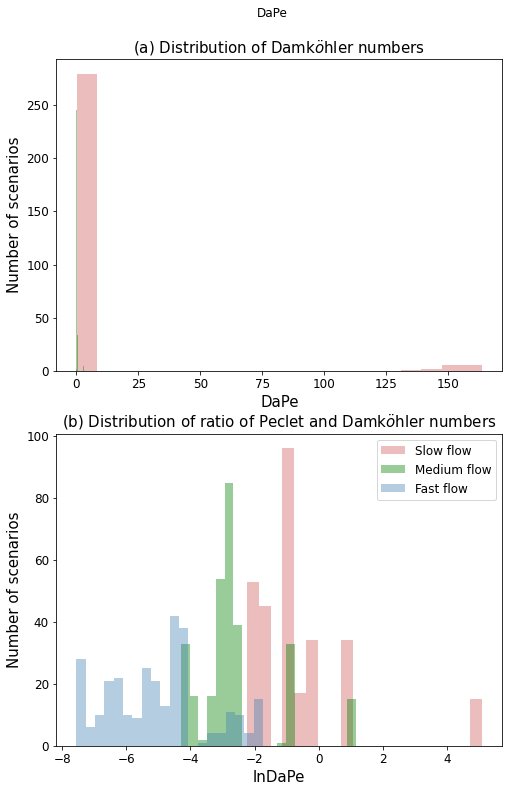

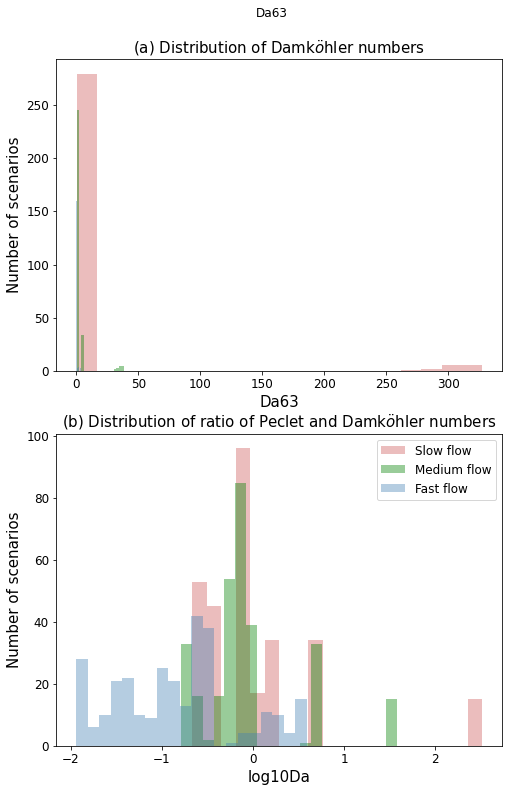

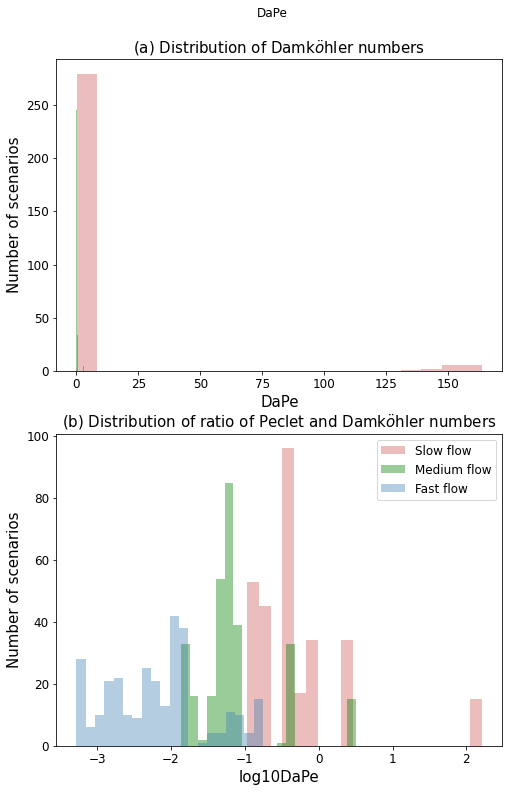

In [12]:
finaldata = timedata
dalist = ["Da63","DaPe", "Da63", "DaPe"]
dapelist = ["lnDa","lnDaPe", "log10Da", "log10DaPe"]
for da,dape in zip(dalist,dapelist):
    fig, (ax1, ax2) = plt.subplots(2, figsize = (8,12))
    fig.suptitle(da)#'Distribution of flow and reaction regime indicators', fontsize = 15)
    
    sns.distplot(finaldata[finaldata["Regime"] == "Slow"][da], color = "indianred", label = "Slow flow", kde = False, bins = 20, ax = ax1)
    sns.distplot(finaldata[finaldata["Regime"] == "Medium"][da], color = "g", label = "Medium flow", kde = False, bins = 20, ax = ax1)
    sns.distplot(finaldata[finaldata["Regime"] == "Fast"][da], color = "steelblue", label = "Fast flow", kde = False, bins = 20, ax = ax1)
    ax1.tick_params(labelsize = 12)
    ax1.set_xlabel (da, fontsize = 15)
    ax1.set_ylabel ("Number of scenarios", fontsize = 15)
    ax1.set_title ("(a) Distribution of Damk$\ddot{o}$hler numbers", fontsize = 15)
    
    sns.distplot(finaldata[finaldata["Regime"] == "Slow"][dape], color = "indianred", label = "Slow flow", kde = False, bins = 20, ax = ax2)
    sns.distplot(finaldata[finaldata["Regime"] == "Medium"][dape], color = "g", label = "Medium flow", kde = False, bins = 20, ax = ax2)
    sns.distplot(finaldata[finaldata["Regime"] == "Fast"][dape], color = "steelblue", label = "Fast flow", kde = False, bins = 20, ax = ax2)
    ax2.tick_params(labelsize = 12)
    ax2.set_xlabel (dape, fontsize = 15)
    ax2.set_ylabel ("Number of scenarios", fontsize = 15)
    ax2.set_title ("(b) Distribution of ratio of Peclet and Damk$\ddot{o}$hler numbers", fontsize = 15)
    plt.legend(fontsize = 12)
    plt.subplots_adjust(top=0.92)

<ipython-input-40-8304cce2bddf>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  amm = mlines.Line2D([], [], Linestyle = 'None', marker = 'o', alpha = 0.5, label="Ammonium")
<ipython-input-40-8304cce2bddf>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  do = mlines.Line2D([], [], Linestyle = 'None', marker = '^', alpha = 0.5, label="DO")
<ipython-input-40-8304cce2bddf>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  nitra = mlines.Line2D([], [], Linestyle = 'None', marker = 's', alpha = 0.5, label="Nitrate")


Text(0, 0.5, 'Impact on O, N removal (%)')

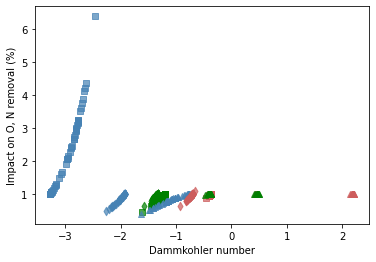

In [40]:
# Figure7 Removal of reactive species with damkohler number and Pe number
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_patch = mpatches.Patch(color="indianred", alpha = 0.5, label="2")
green_patch = mpatches.Patch(color="g", alpha = 0.5, label="11")
blue_patch = mpatches.Patch(color="steelblue", alpha = 0.5, label="22")
amm = mlines.Line2D([], [], Linestyle = 'None', marker = 'o', alpha = 0.5, label="Ammonium")
do = mlines.Line2D([], [], Linestyle = 'None', marker = '^', alpha = 0.5, label="DO")
nitra = mlines.Line2D([], [], Linestyle = 'None', marker = 's', alpha = 0.5, label="Nitrate")
patchlist = [red_patch, green_patch, blue_patch, do, amm, nitra]
my_pal = {2:"indianred", 11:"g", 22:"steelblue",
         "Slow":"indianred", "Medium":"g", "Fast":"steelblue"}
my_mark = {"Ammonium":"o", "DO":"^", "Nitrate":"s","DOC":"d", "Nitrogen":"s","TOC":"d"}

finaldata = timedata
plt.figure()
for c in ["Nitrogen", "DO", "TOC"]:
    for p in Regimes:
        data = finaldata[(finaldata['Regime']==p) & (finaldata['Chem']==c)]
        plt.scatter(data['log10DaPe'],data['reldelmassflux_spatial_fraction'], color = my_pal[p], marker = my_mark[c], alpha = 0.7)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(right = 0.0002)
#plt.ylim(top = 8)
plt.xlabel ("Dammkohler number")
plt.ylabel ("Impact on O, N removal (%)")

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

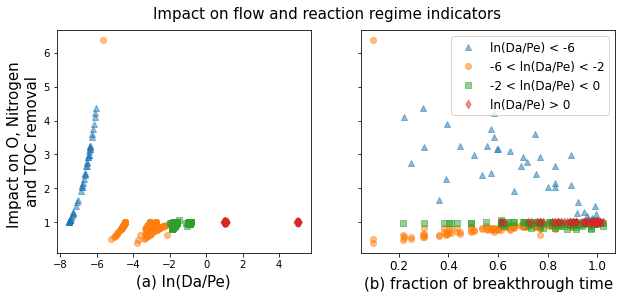

In [56]:
#Log transformation of Da/Pe. Skip ahead if you are looking for log transformation of Pe/Da
dapechems = ["DO", "Nitrogen","TOC"]
chemdata = timedata[timedata['Chem'].isin (dapechems)]
#chemdata = timedata
mymarklist = ["^", "o", "s", "d"]

#For log10 tranformation:
#chemdata.loc[chemdata["log10Da"] > 1, "PeDamark"] = 3
#chemdata.loc[(chemdata["log10Da"] > 0) & (chemdata["log10Da"] < 1), "PeDamark"] = 2
#chemdata.loc[(chemdata["log10Da"] > -1) & (chemdata["log10Da"] < 0), "PeDamark"] = 1
#chemdata.loc[(chemdata["log10Da"] < -1), "PeDamark"] = 0
#labels = {3 : "logDa > 1",
#          2 : "0 < logDa < 1",
#          1 : "-1 < logDa < 0",
#         0 : "logDa < -1"}

#For log10 tranformation:
#chemdata.loc[chemdata["log10DaPe"] > 0, "PeDamark"] = 3
#chemdata.loc[(chemdata["log10DaPe"] > -1) & (chemdata["log10DaPe"] < 0), "PeDamark"] = 2
#chemdata.loc[(chemdata["log10DaPe"] > -2.5) & (chemdata["log10DaPe"] < -1), "PeDamark"] = 1
#chemdata.loc[(chemdata["log10DaPe"] < -2.5), "PeDamark"] = 0
#labels = {3 : "log(Da/Pe) > 0",
#          2 : "-1 < log(Da/Pe) < 0",
#          1 : "-2.5 < log(Da/Pe) < -1",
#         0 : "log(Da/Pe) < -2.5"}

#For natural log tranformation:
#chemdata.loc[chemdata["lnDa"] > 2, "PeDamark"] = 3
#chemdata.loc[(chemdata["lnDa"] > 1) & (chemdata["lnDa"] < 2), "PeDamark"] = 2
#chemdata.loc[(chemdata["lnDa"] > -2.2) & (chemdata["lnDa"] < 1), "PeDamark"] = 1
#chemdata.loc[(chemdata["lnDa"] < -2.2), "PeDamark"] = 0
#labels = {3 : "lnDa > 2",
#          2 : "1 < lnDa < 2",
#          1 : "-2.2 < lnDa < 1",
#         0 : "lnDa < -2.2"}

chemdata.loc[chemdata["lnDaPe"] > 0, "PeDamark"] = 3
chemdata.loc[(chemdata["lnDaPe"] > -2) & (chemdata["lnDaPe"] < 0), "PeDamark"] = 2
chemdata.loc[(chemdata["lnDaPe"] > -6) & (chemdata["lnDaPe"] < -2), "PeDamark"] = 1
chemdata.loc[(chemdata["lnDaPe"] < -6), "PeDamark"] = 0
labels = {3 : "ln(Da/Pe) > 0",
          2 : "-2 < ln(Da/Pe) < 0",
          1 : "-6 < ln(Da/Pe) < -2",
         0 : "ln(Da/Pe) < -6"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4), sharey = True)
fig.suptitle('Impact on flow and reaction regime indicators', fontsize = 15)

for frac in [0,1,2,3]:
    data = chemdata[chemdata["PeDamark"] == frac]
    ax1.scatter(data["lnDaPe"], data["reldelmassflux_spatial_fraction"], marker = mymarklist[frac], label = labels[frac], alpha = 0.5)
    ax2.scatter(data["fraction"], data["reldelmassflux_spatial_fraction"], marker = mymarklist[frac], label = labels[frac], alpha = 0.5)
#ax1.set_xscale("log")
ax1.set_xlabel ("(a) ln(Da/Pe)", fontsize = 15)
ax2.set_xlabel ("(b) fraction of breakthrough time", fontsize = 15)
ax1.set_ylabel ("Impact on O, Nitrogen \nand TOC removal", fontsize = 15)
#ax1.set_xlim(left = -5)
plt.tick_params(labelsize = 12)
plt.subplots_adjust (top = 0.9)
plt.legend(fontsize = 12)

<ipython-input-39-3bf256a22131>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  amm = mlines.Line2D([], [], Linestyle = 'None', marker = 'o', alpha = 0.5, label="Ammonium")
<ipython-input-39-3bf256a22131>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  do = mlines.Line2D([], [], Linestyle = 'None', marker = '^', alpha = 0.5, label="DO")
<ipython-input-39-3bf256a22131>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  nitra = mlines.Line2D([], [], Linestyle = 'None', marker = 's', alpha = 0.5, label="Nitrate")


Text(0, 0.5, 'Impact on O, N removal (%)')

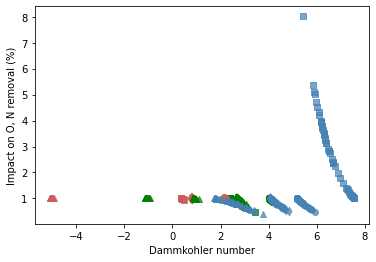

In [39]:
# Figure7 Removal of reactive species with damkohler number and Pe number
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
red_patch = mpatches.Patch(color="indianred", alpha = 0.5, label="2")
green_patch = mpatches.Patch(color="g", alpha = 0.5, label="11")
blue_patch = mpatches.Patch(color="steelblue", alpha = 0.5, label="22")
amm = mlines.Line2D([], [], Linestyle = 'None', marker = 'o', alpha = 0.5, label="Ammonium")
do = mlines.Line2D([], [], Linestyle = 'None', marker = '^', alpha = 0.5, label="DO")
nitra = mlines.Line2D([], [], Linestyle = 'None', marker = 's', alpha = 0.5, label="Nitrate")
patchlist = [red_patch, green_patch, blue_patch, do, amm, nitra]
my_pal = {2:"indianred", 11:"g", 22:"steelblue",
         "Slow":"indianred", "Medium":"g", "Fast":"steelblue"}
my_mark = {"Ammonium":"o", "DO":"^", "Nitrate":"s","DOC":"d"}

finaldata = timedata
plt.figure()
for c in ["Nitrate","Ammonium", "DOC","DO"]:
    for p in Regimes:
        data = finaldata[(finaldata['Regime']==p) & (finaldata['Chem']==c)]
        plt.scatter(data['logPeDa'],data['reldelmassflux_spatial_fraction'], color = my_pal[p], marker = my_mark[c], alpha = 0.7)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(right = 0.0002)
#plt.ylim(top = 8)
plt.xlabel ("Dammkohler number")
plt.ylabel ("Impact on O, N removal (%)")

C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\khurana\Anaconda3\envs\mlsm\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

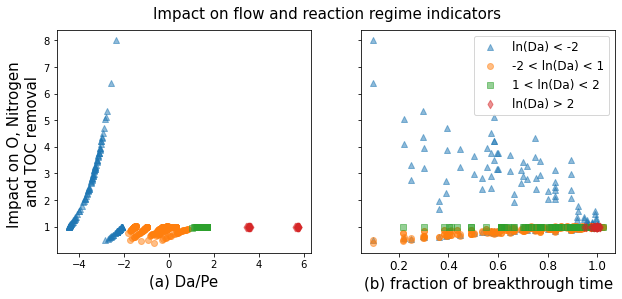

In [30]:

#Log transformation of Da/Pe. Skip ahead if you are looking for log transformation of Pe/Da
dapechems = ["DO", "Ammonium","Nitrate","DOC","Nitrogen", "DOC"]
chemdata = timedata[timedata['Chem'].isin (dapechems)]
#chemdata = timedata
mymarklist = ["^", "o", "s", "d"]

#For log tranformation:
chemdata.loc[chemdata["logDa"] > 2, "PeDamark"] = 3
chemdata.loc[(chemdata["logDa"] > 1) & (chemdata["logDa"] < 2), "PeDamark"] = 2
chemdata.loc[(chemdata["logDa"] > -2) & (chemdata["logDa"] < 1), "PeDamark"] = 1
chemdata.loc[(chemdata["logDa"] < -2), "PeDamark"] = 0
labels = {3 : "ln(Da) > 2",
          2 : "1 < ln(Da) < 2",
          1 : "-2 < ln(Da) < 1",
         0 : "ln(Da) < -2"}

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4), sharey = True)
fig.suptitle('Impact on flow and reaction regime indicators', fontsize = 15)

for frac in [0,1,2,3]:
    data = chemdata[chemdata["PeDamark"] == frac]
    ax1.scatter(data["logDa"], data["reldelmassflux_spatial_fraction"], marker = mymarklist[frac], label = labels[frac], alpha = 0.5)
    ax2.scatter(data["fraction"], data["reldelmassflux_spatial_fraction"], marker = mymarklist[frac], label = labels[frac], alpha = 0.5)
#ax1.set_xscale("log")
ax1.set_xlabel ("(a) Da/Pe", fontsize = 15)
ax2.set_xlabel ("(b) fraction of breakthrough time", fontsize = 15)
ax1.set_ylabel ("Impact on O, Nitrogen \nand TOC removal", fontsize = 15)
#ax1.set_ylim(top=1.1)
plt.tick_params(labelsize = 12)
plt.subplots_adjust (top = 0.9)
plt.legend(fontsize = 12)